In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import re, string

import time

In [2]:
!ls

Classification.ipynb	   crawl-300d-2M.vec.zip  train_tiny.csv
classification_tiny.ipynb  Topic_modelling.ipynb  train_tiny_folds.csv
crawl-300d-2M.vec	   train.csv


In [48]:
#punctuation = list(string.punctuation)

my_stopwords = nltk.corpus.stopwords.words('english')# punctuation

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def tokenize(s):
    output = re.sub(r'\d+', '', s) # remove numbers 
    output = remove_links(output)
    result = re_tok.sub(r' \1 ', output).split() 
    result = [word for word in result if len(word)>2]
    result = [word for word in result if word not in my_stopwords]
    return result

xtrain shape (8089, 40659)
xtest shape (2023, 40659)
In PCA
xtrain pca shape (8089, 8000)
explained variance: 0.999779296339537
target counts:
 open      7921
closed     168
Name: OpenStatus, dtype: int64
time elapsed: 32.38869881629944
preds unique: ['closed' 'open']
Fold: 0
Accuracy=0.9649036085022245


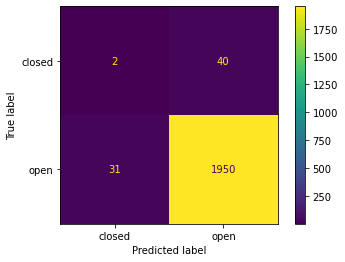

 
xtrain shape (8089, 40576)
xtest shape (2023, 40576)
In PCA
xtrain pca shape (8089, 8000)
explained variance: 0.9997657381807837
target counts:
 open      7921
closed     168
Name: OpenStatus, dtype: int64
time elapsed: 43.275904178619385
preds unique: ['closed' 'open']
Fold: 1
Accuracy=0.9663865546218487


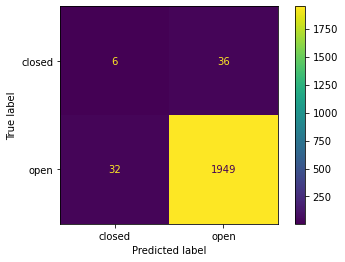

 
xtrain shape (8090, 40035)
xtest shape (2022, 40035)
In PCA
xtrain pca shape (8090, 8000)
explained variance: 0.9997759519538298
target counts:
 open      7922
closed     168
Name: OpenStatus, dtype: int64
time elapsed: 32.229809522628784
preds unique: ['closed' 'open']
Fold: 2
Accuracy=0.966864490603363


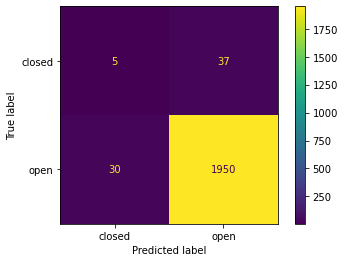

 
xtrain shape (8090, 40622)
xtest shape (2022, 40622)
In PCA
xtrain pca shape (8090, 8000)
explained variance: 0.9997843853635998
target counts:
 open      7922
closed     168
Name: OpenStatus, dtype: int64
time elapsed: 32.403669357299805
preds unique: ['closed' 'open']
Fold: 3
Accuracy=0.9564787339268052


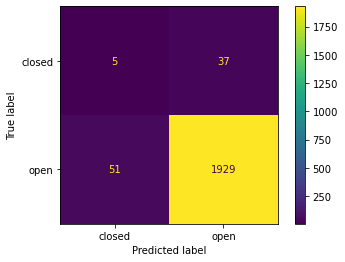

 
xtrain shape (8090, 40311)
xtest shape (2022, 40311)
In PCA
xtrain pca shape (8090, 8000)
explained variance: 0.9997646059324347
target counts:
 open      7922
closed     168
Name: OpenStatus, dtype: int64
time elapsed: 30.720006465911865
preds unique: ['closed' 'open']
Fold: 4
Accuracy=0.9658753709198813


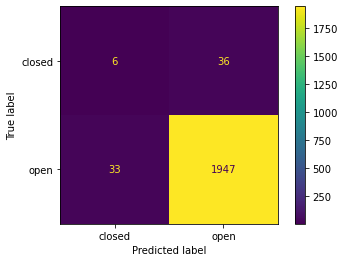

In [4]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

if __name__=="__main__":
    
    df = pd.read_csv("train_tiny_folds.csv")
    
    for fold_ in range(1):
        train_df = df[df.kfold != fold_].reset_index(drop = True)
        test_df = df[df.kfold == fold_].reset_index(drop = True)
    
        vectorizer = TfidfVectorizer(tokenizer = tokenize,
                                     token_pattern=None)
        # fit TFIDF
        xtrain = vectorizer.fit(train_df.BodyMarkdown)
        # transform
        xtrain = vectorizer.transform(train_df.BodyMarkdown)
        xtest = vectorizer.transform(test_df.BodyMarkdown)
        
        print('xtrain shape', xtrain.shape)
        print('xtest shape', xtest.shape)
        # perform PCA
        svd = TruncatedSVD(n_components=8000, n_iter=7, random_state=42)
        print('In PCA')
        svd.fit(xtrain)
        xtrain = svd.transform(xtrain)
        xtest = svd.transform(xtest)
        print('xtrain pca shape', xtrain.shape)
        print('explained variance:', svd.explained_variance_ratio_.sum())
        # target
        ytrain = train_df.OpenStatus
        ytest = test_df.OpenStatus
        print('target counts:\n', train_df.OpenStatus.value_counts())
        #model
        model = linear_model.LogisticRegression(max_iter=5000,class_weight='balanced',
                                                n_jobs=-1
                                               )
        
        to=time.time()
        # fit the model
        model.fit(xtrain,train_df.OpenStatus)
        
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-to
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold: {fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")
        

### use embeddings

In [53]:
import numpy as np
def sentence_to_vec(s,embedding_dict,stop_words,tokenizer):
    """
    s: sentence, string
    embedding_dict: dictionary word: vector
    stop_words: list of stop words
    tokenizer: tokenizer function
    """
    # convert sentence to string and lowercase it
   # words = str(s).lower()
    # tokenize the sentence
    words = s
    words = tokenizer(words)
    # remove stop words
   # words =[w for w in words if not w in stop_words]
    
    # keep only alpha numeric tokens
    words =[w for w in words if w.isalpha()]
    # initialize empty list to store embeddings
    M = []
    for w in words:
        # for every word, get the embedding from the dictionary
        # and append to the list of embeddings
        if w in embedding_dict:
            M.append(embedding_dict[w])
        # if we don't have any vectors return zeros
    if len(M)==0:
        return np.zeros(300)
    # convert list of embeddings to array
    M = np.array(M)
    # calculate sum over axis=0
    v = M.sum(axis=0)
    return v/np.sqrt((v**2).sum())       

In [5]:
import io
def load_vectors(fname):
    fin = io.open(fname,'r',
                  encoding ='utf-8',
                  newline = '\n',
                  errors='ignore'
                 )
    n,d = map(int,fin.readline().split())
    data ={}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]]=list(map(float,tokens[1:]))
    return data    

In [6]:
!ls

Classification.ipynb	   crawl-300d-2M.vec.zip  train_tiny.csv
classification_tiny.ipynb  Topic_modelling.ipynb  train_tiny_folds.csv
crawl-300d-2M.vec	   train.csv


In [7]:
print("Loading embeddings")
embeddings = load_vectors("crawl-300d-2M.vec")

Loading embeddings


In [8]:
df = pd.read_csv("train_tiny_folds.csv")

In [10]:
df.head(3)

,Title,BodyMarkdown,OpenStatus,kfold
0,How to set a font to LabelField text in Blackb...,i don't know how to apply font style to a text...,open,0
1,Blend multiple jQuery files - Best practice?,I'm starting to learn JavaScript and jQuery. I...,open,0
2,stored procedure calling data in a different s...,"SQL 2008 R2:\r\nNormally, we create our table,...",open,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         10112 non-null  object
 1   BodyMarkdown  10112 non-null  object
 2   OpenStatus    10112 non-null  object
 3   kfold         10112 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 316.1+ KB


creating sentence embedding
(10112, 300)
training fold: {fold_}
xtrain shape (8089, 300)
time elapsed: 0.9798183441162109
preds unique: ['closed' 'open']
Fold: 0
Accuracy=0.8260009886307464


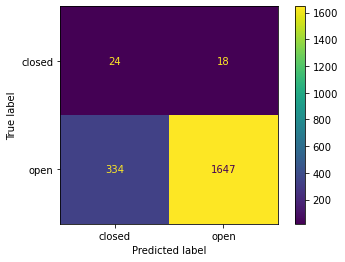

 
training fold: {fold_}
xtrain shape (8089, 300)
time elapsed: 1.2581706047058105
preds unique: ['closed' 'open']
Fold: 1
Accuracy=0.8082056351952546


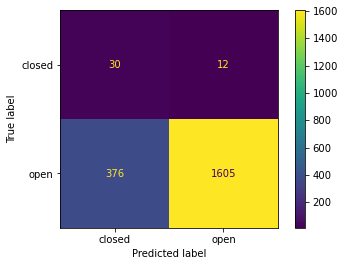

 
training fold: {fold_}
xtrain shape (8090, 300)
time elapsed: 1.3643860816955566
preds unique: ['closed' 'open']
Fold: 2
Accuracy=0.83135509396637


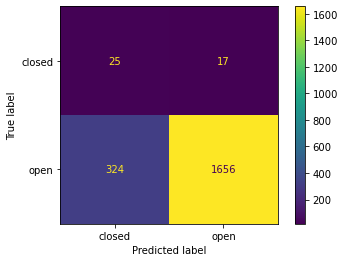

 
training fold: {fold_}
xtrain shape (8090, 300)
time elapsed: 1.2118966579437256
preds unique: ['closed' 'open']
Fold: 3
Accuracy=0.8254203758654797


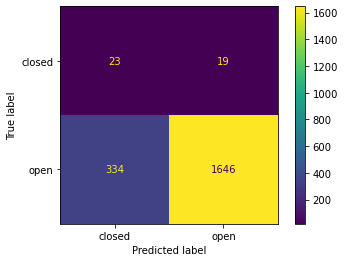

 
training fold: {fold_}
xtrain shape (8090, 300)
time elapsed: 1.236769437789917
preds unique: ['closed' 'open']
Fold: 4
Accuracy=0.8130563798219584


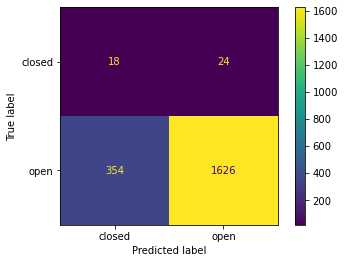

In [59]:
#create sentence embeddings
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

if __name__=="__main__":
    
    print("creating sentence embedding")
    vectors =[]
    for body in df.BodyMarkdown.values:
        vectors.append(
            sentence_to_vec(s= body,
                           embedding_dict = embeddings,
                           stop_words =my_stopwords,
                           tokenizer=tokenize
                           )
        )
    vectors = np.array(vectors)    
    print(vectors.shape)
    
    y=df.OpenStatus.values
    # initialize the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)
    # fill the new kfold column
    for fold_,(t_,v_) in enumerate(kf.split(X=vectors,y=y)):
        print("training fold: {fold_}")
        #temp dataframe for train and test
        xtrain=vectors[t_,:]
        ytrain=y[t_]
        print('xtrain shape',xtrain.shape)
        
        xtest=vectors[v_,:]
        ytest =y[v_]
        model=linear_model.LogisticRegression(max_iter=5000,
                                              class_weight='balanced',
                                              n_jobs=-1)
        t0=time.time()
        #fit the model on training data 
        model.fit(xtrain,ytrain)
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-t0
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold: {fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")

creating sentence embedding
(10112, 300)
training fold: {fold_}
xtrain shape (8089, 300)
time elapsed: 1.0460970401763916
preds unique: ['open']
Fold: 0
Accuracy=0.9792387543252595


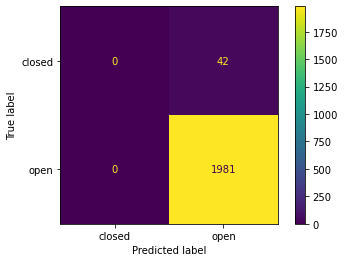

 
training fold: {fold_}
xtrain shape (8089, 300)
time elapsed: 1.0467939376831055
preds unique: ['open']
Fold: 1
Accuracy=0.9792387543252595


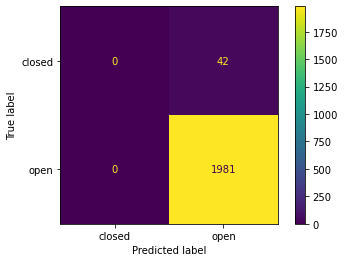

 
training fold: {fold_}
xtrain shape (8090, 300)
time elapsed: 1.046877145767212
preds unique: ['open']
Fold: 2
Accuracy=0.9792284866468842


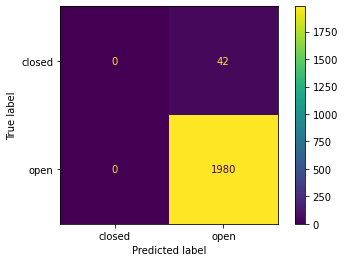

 
training fold: {fold_}
xtrain shape (8090, 300)
time elapsed: 1.0481696128845215
preds unique: ['open']
Fold: 3
Accuracy=0.9792284866468842


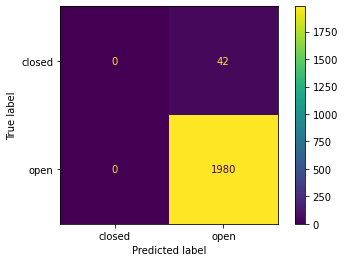

 
training fold: {fold_}
xtrain shape (8090, 300)
time elapsed: 1.0379867553710938
preds unique: ['open']
Fold: 4
Accuracy=0.9792284866468842


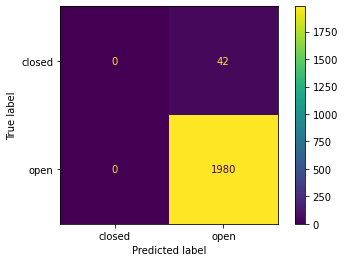

In [63]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

if __name__=="__main__":
    
    print("creating sentence embedding")
    vectors =[]
    for body in df.BodyMarkdown.values:
        vectors.append(
            sentence_to_vec(s= body,
                           embedding_dict = embeddings,
                           stop_words =my_stopwords,
                           tokenizer=tokenize
                           )
        )
    vectors = np.array(vectors)    
    print(vectors.shape)
    
    y=df.OpenStatus.values
    # initialize the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)
    # fill the new kfold column
    for fold_,(t_,v_) in enumerate(kf.split(X=vectors,y=y)):
        print("training fold: {fold_}")
        #temp dataframe for train and test
        xtrain=vectors[t_,:]
        ytrain=y[t_]
        print('xtrain shape',xtrain.shape)
        
        xtest=vectors[v_,:]
        ytest =y[v_]
        model=RandomForestClassifier(n_estimators =100, 
                                     max_features='sqrt',random_state=0,
                                     max_depth=10,n_jobs=-1)
        t0=time.time()
        #fit the model on training data 
        model.fit(xtrain,ytrain)
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-t0
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold: {fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")